<a href="https://colab.research.google.com/github/BimsaraS99/multiclass-classification-pytorch/blob/main/pytorch_multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Multi-class classification - PyTorch***

### ***Import libraries***

In [ ]:
import torch
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy

### ***Creating and splitting sample dataset***

***Creating sample dataset***

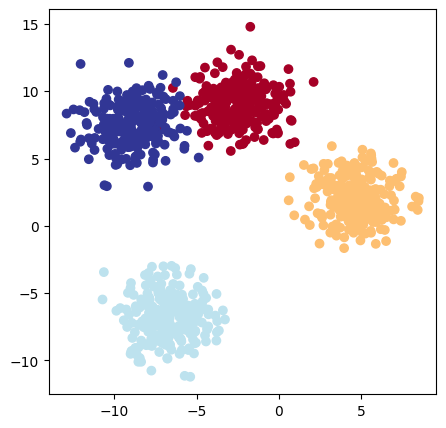

In [ ]:
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=2, # X features
    centers=4, # y labels
    cluster_std=1.5,
    random_state=42
)
plt.figure(figsize=(5, 5))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

***Converting dataset into Tensor (Numpy to Tensor)***

In [ ]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


***Splitting dataset to train and test datasets***

In [ ]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=42
)
print(X_blob_train.shape, X_blob_test.shape, y_blob_train.shape, y_blob_test.shape)

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


***Device agnostic code***

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### ***Implementation of the multi-class classification model***

When you use `nn.CrossEntropyLoss()` as the loss function, you do not need to apply softmax explicitly in your model's forward function. The CrossEntropyLoss function expects raw logits (the output of the last linear layer) as input, and it applies softmax internally to compute the loss. This is why the final layer in the model is a linear layer (`self.fc2`) without an explicit softmax activation.

***Implementation of the model***

In [ ]:
class Multiclassifier(nn.Module):
  def __init__(self, in_size, out_size, hidden_units):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(in_features=in_size, out_features=hidden_units), # input layer
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units), # dense layer
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=out_size)
        # The reason why we do not use the softmax at the last layer, has mentioned above comment
    )

  def forward(self, x):
    return self.model(x)

# creating an instance with the model class
model = Multiclassifier(in_size=2,
                    out_size=4,
                    hidden_units=8).to(device)
model.to(device)

Multiclassifier(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

***Loss and Optimizer***

In [ ]:
LEARNING_RATE = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=LEARNING_RATE)

***Testing the implentation of the model with a forward pass before the training process (Single data raw input)***

In [ ]:
y_logits = model(X_blob_train[0].to(device)) # raw output of the model
print("Raw output of the model: ", y_logits, y_logits.shape)

y_pred_probs = torch.softmax(y_logits.unsqueeze(0), dim=1) # passing through the softmax fucntion
print("Passing through the softmax: ", y_pred_probs, "Sum of the probabilities: ", torch.sum(y_pred_probs))

print("Predicted class: ", torch.argmax(y_pred_probs))

Raw output of the model:  tensor([ 0.3209,  0.2388,  0.0443, -0.4472], grad_fn=<ViewBackward0>) torch.Size([4])
Passing through the softmax:  tensor([[0.3181, 0.2930, 0.2412, 0.1476]], grad_fn=<SoftmaxBackward0>) Sum of the probabilities:  tensor(1.0000, grad_fn=<SumBackward0>)
Predicted class:  tensor(0)


### ***Implemention of the training loop of the model***

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

***Training loop***

In [ ]:
torch.manual_seed(42)
epochs = 100

# Put data into the particular device CPU or GPU
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(epochs):
    model.train()  # set the model to training mode

    y_logits = model(X_blob_train)
    loss = loss_fn(y_logits, y_blob_train)

    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()  # reset the optimizer
    loss.backward()  # backward propagation
    optimizer.step()

    # evaluation of the model
    if epoch % 1 == 0:
        model.eval()  # set the model to evaluation mode
        with torch.inference_mode():
            test_logits = model(X_blob_test)
            test_loss = loss_fn(test_logits, y_blob_test)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

        # Save the training and testing loss and accuracy
        train_losses.append(loss.item())
        train_accuracies.append(acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.51031, Acc: 7.00% | Test Loss: 1.34209, Test Acc: 9.50%
Epoch: 1 | Loss: 1.33722, Acc: 10.50% | Test Loss: 1.27746, Test Acc: 29.00%
Epoch: 2 | Loss: 1.27079, Acc: 31.00% | Test Loss: 1.22209, Test Acc: 52.50%
Epoch: 3 | Loss: 1.21847, Acc: 55.88% | Test Loss: 1.17836, Test Acc: 63.50%
Epoch: 4 | Loss: 1.17371, Acc: 66.75% | Test Loss: 1.13494, Test Acc: 68.50%
Epoch: 5 | Loss: 1.13113, Acc: 69.88% | Test Loss: 1.09178, Test Acc: 70.50%
Epoch: 6 | Loss: 1.08698, Acc: 71.88% | Test Loss: 1.04557, Test Acc: 76.00%
Epoch: 7 | Loss: 1.04106, Acc: 76.50% | Test Loss: 0.99971, Test Acc: 90.50%
Epoch: 8 | Loss: 0.99333, Acc: 88.75% | Test Loss: 0.95085, Test Acc: 91.50%
Epoch: 9 | Loss: 0.94431, Acc: 90.62% | Test Loss: 0.90402, Test Acc: 91.00%
Epoch: 10 | Loss: 0.89505, Acc: 91.62% | Test Loss: 0.85645, Test Acc: 93.00%
Epoch: 11 | Loss: 0.84611, Acc: 91.75% | Test Loss: 0.81092, Test Acc: 92.50%
Epoch: 12 | Loss: 0.79773, Acc: 93.00% | Test Loss: 0.76512, Test Acc: 92.50

***Plotting graphs***

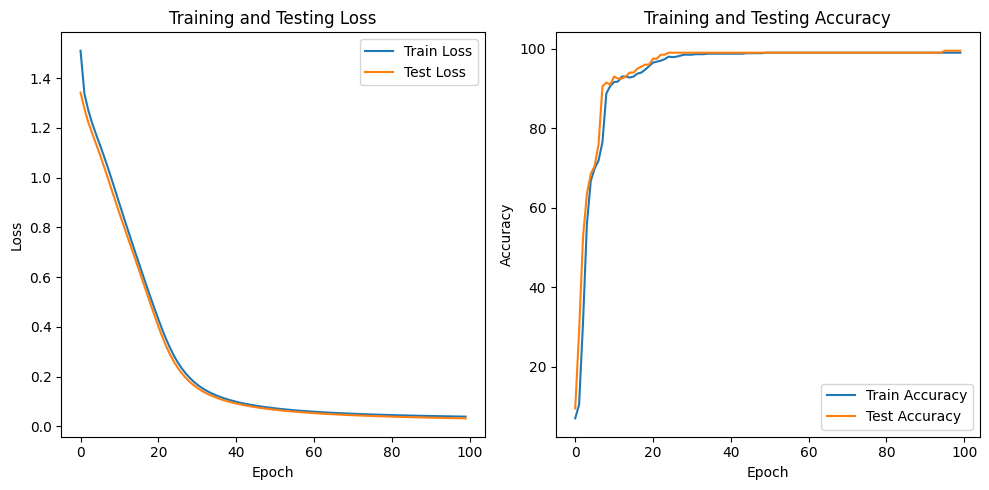

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### ***Evaluate the model with test dataset***

***Find the test accuracy***

In [ ]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_blob_test)
  y_pred_probs = torch.softmax(y_logits, dim=1)

  y_preds = y_pred_probs.argmax(dim=1)

  print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
  print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


***Plotting the model***

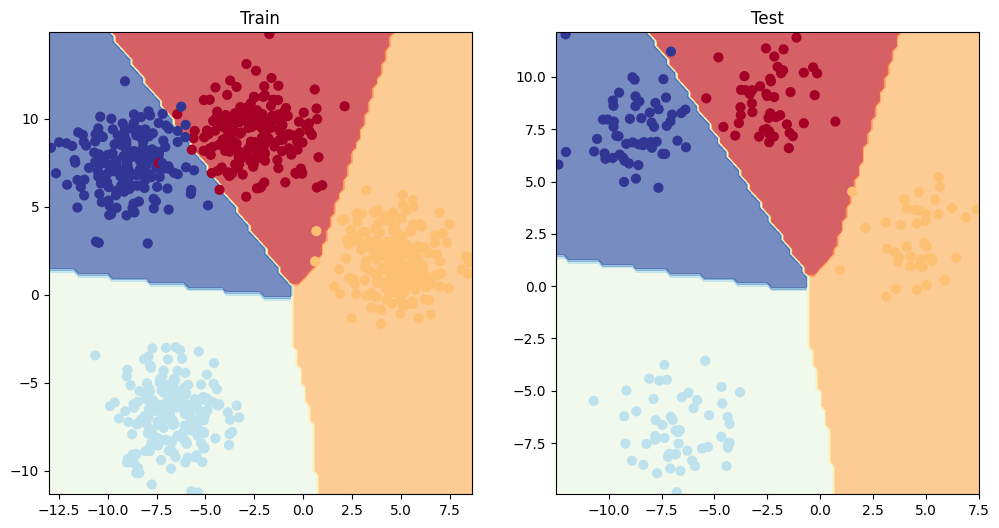

In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)

## ***Classification evaluation methods***

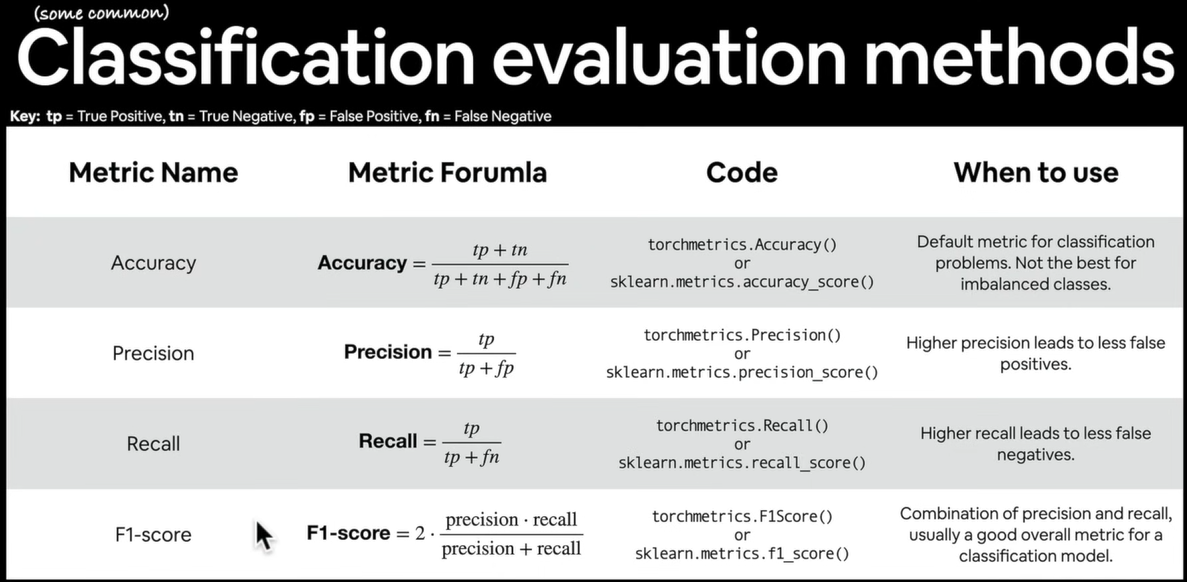